The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[WARN] Failed to load descriptor from ./mapping_schemes/mapping_scheme_378.py: No module named 'adi._adi_cffi'
[INFO] Loaded 25 descriptor(s) from ./mapping_schemes
Selected mapping: mapping_436
Score: 3
[[-3.1198633 -2.1447656 -3.9001367 ... -2.340078   2.9250586  3.9001563]
 [11.309824   1.7551367 -4.094961  ...  7.4099216  4.8747654  3.7048438]]


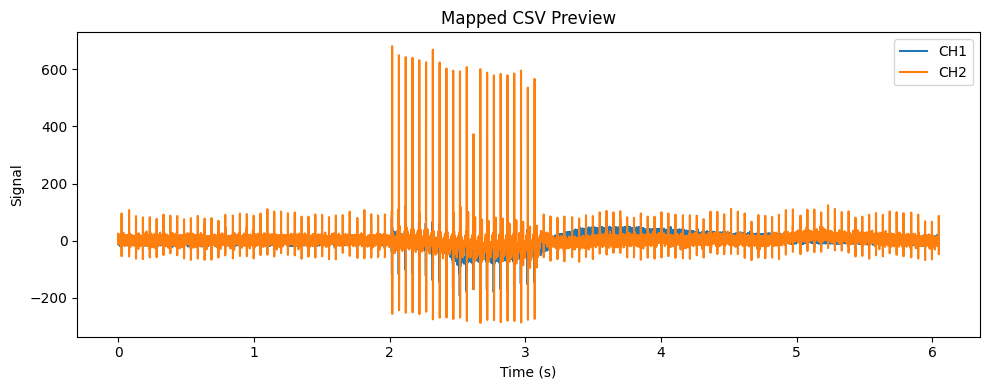

✅ Saved standardized data to: output/PilotExpt26_220401_133140.rhd


In [25]:
%matplotlib inline
%load_ext autoreload
%autoreload 3

import matplotlib.pyplot as plt
from pathlib import Path
from sparcfuse.utils import match_best_mapping, load_all_descriptors, save_standardized_output

# Load all descriptor files from folder
descriptors = load_all_descriptors()

# File to convert
filepath = "../downloads/436/PilotExpt26_220401_133140.rhd"
filename = Path(filepath).name

# Optional: specify SPARC ID for faster mapping
# Works also without sparc_id as the other csv mapping schemes works well on this CSV file
result = match_best_mapping(descriptors, filepath, sparc_id=436)

# Check if mapping was successful
if result["descriptor"] is None:
    raise RuntimeError("No suitable mapping descriptor found.")

# Show mapping result
print("Selected mapping:", result['descriptor']['id'])
print("Score:", result['score'])


# Preview signal
time = result['result']['time']
signals = result['result']['signals']

print(signals)

plt.figure(figsize=(10, 4))
for i, ch in enumerate(signals):
    plt.plot(time, ch, label=f"CH{i+1}")
plt.xlabel("Time (s)")
plt.ylabel("Signal")
plt.title("Mapped CSV Preview")
plt.legend()
plt.tight_layout()
plt.show()

# Save to standardized .npz format in ./output
output_dir = Path("../output")
output_dir.mkdir(parents=True, exist_ok=True)

output_path = output_dir / filename.replace(".csv", ".npz")

save_standardized_output(
    output_path=output_path,
    result_dict=result["result"],
    descriptor=result["descriptor"],
    original_filename=filename,
    annotations=result["result"].get("annotations", []),
    metadata_overrides=None,
    file_format="npz"
)

print(f"✅ Saved standardized data to: {output_path}")


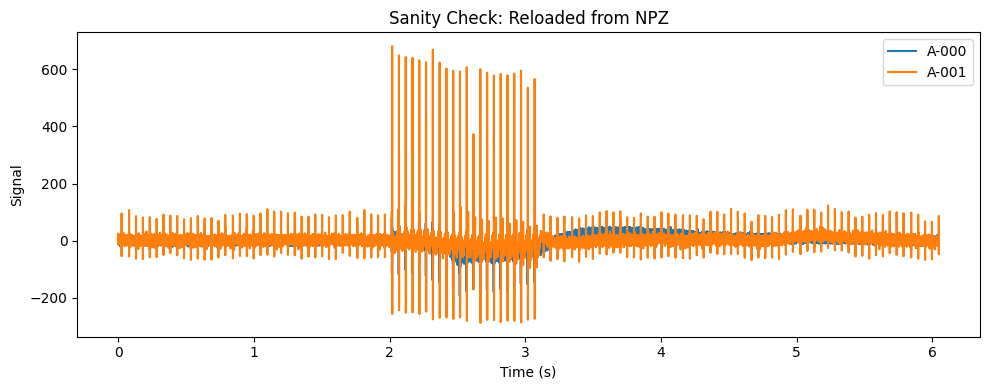

{'time_units': 'seconds', 'time_auto_generated': False, 'source_format': '.rhd', 'database_id': 'unknown', 'sampling_frequency': np.float64(30000.0), 'channel_names': [np.str_('A-000'), np.str_('A-001')], 'channel_units': ['unknown', 'unknown'], 'version': 'v1.0', 'upload_date': '2025-07-30', 'conversion_date': '2025-07-30', 'auto_mapped': True, 'doi': 'unknown', 'original_file_name': 'PilotExpt26_220401_133140.rhd', 'sparc_subject_id': 'unknown', 'species': 'Rat', 'anatomical_location': 'unknown', 'modality': 'unknown', 'experimenter': 'Unknown', 'institution': 'unknown', 'sweep_mode': False, 'notes': 'Mapped using SPARCFUSE'}
shape of time: (181504,)
shape of signals: (2, 181504)


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Load the .npz file
npz_path = Path("../output/PilotExpt26_220401_133140.npz")
data = np.load(npz_path, allow_pickle=True)

# Extract arrays
time = data["time"]
signals = data["signals"]
metadata = data["metadata"].item()  # metadata is saved as a Python dict
channel_names = metadata.get("channel_names", [f"CH{i+1}" for i in range(len(signals))])

# Plot
plt.figure(figsize=(10, 4))
for i, ch in enumerate(signals):
    plt.plot(time, ch, label=channel_names[i])
plt.xlabel("Time (s)")
plt.ylabel("Signal")
plt.title("Sanity Check: Reloaded from NPZ")
plt.legend()
plt.tight_layout()
plt.show()

print(data['metadata'])

print("shape of time:", time.shape)
print("shape of signals:", signals.shape)

In [ ]:
# Deep inspection of a MATLAB *.mat file  ────────────────────────────────────────
# Put the file you want to explore in mat_path and run the cell.

mat_path =  "../downloads/PilotExpt26_220401_133140.mat"
# ───────────────────────────────────────────────────────────────────────────────

from pathlib import Path
import numpy as np
from scipy.io import loadmat            # for v5 / v7 (<7.3) files

try:                                    # optional: v7.3 reader
    import mat73                        # pip install mat73
except ImportError:
    mat73 = None

# ── helpers ────────────────────────────────────────────────────────────────────
def _load_any_mat(fp: str):
    """Load any MATLAB file (v5 – v7.3) and return a clean dict."""
    try:                                # classic MAT reader first
        d = loadmat(fp, squeeze_me=True, struct_as_record=False)
        return {k: v for k, v in d.items() if not k.startswith("__")}
    except NotImplementedError:         # v7.3 (HDF5) needs mat73
        if mat73 is None:
            raise RuntimeError(
                "MAT‑file looks like v7.3. Install mat73:  pip install mat73"
            )
        return mat73.loadmat(fp)

# ---------------------------------------------------------------------------
# recognise scipy.io.matlab.mio5_params.mat_struct as a struct as well
# ---------------------------------------------------------------------------
import types
from scipy.io.matlab.mio5_params import mat_struct   # import the class

def _is_struct(obj):
    """Return True for MATLAB structs loaded by either SciPy or mat73."""
    return isinstance(
        obj,
        (
            np.void,          # numpy record (SciPy when struct_as_record=True)
            mat_struct,       # the 'mat_struct' wrapper (default SciPy output)
            dict,             # mat73 returns dicts
        ),
    )

def _struct_fields(obj):
    """Yield (field_name, value) pairs from any recognised struct proxy."""
    if isinstance(obj, dict):                    # mat73
        yield from obj.items()
    elif isinstance(obj, np.void):               # numpy.void (rare)
        for name in obj.dtype.names:
            yield name, getattr(obj, name)
    elif isinstance(obj, mat_struct):            # the usual SciPy case
        for name in obj._fieldnames:
            yield name, getattr(obj, name)

def _summarize(val):
    """Return a concise one‑liner summary of a value."""
    if isinstance(val, np.ndarray):
        return f"ndarray {val.shape} dtype={val.dtype}"
    if np.isscalar(val):
        return f"{type(val).__name__} {val}"
    if isinstance(val, (list, tuple)):
        return f"{type(val).__name__} len={len(val)}"
    if _is_struct(val):
        return "struct"
    return type(val).__name__

def _rec_print(obj, name, indent=0, depth=0, max_depth=4):
    """Recursive pretty‑printer for nested MATLAB structures."""
    pad = "    " * indent
    print(f"{pad}• {name:<20} {_summarize(obj)}")
    if depth >= max_depth:
        return
    # Dive into structs
    if _is_struct(obj):
        for k, v in _struct_fields(obj):
            _rec_print(v, k, indent + 1, depth + 1, max_depth)
    # Dive into homogeneous list/tuple of structs or ndarrays
    elif isinstance(obj, (list, tuple)) and obj and all(_is_struct(x) for x in obj):
        for i, v in enumerate(obj[:5]):           # show at most first 5
            _rec_print(v, f"[{i}]", indent + 1, depth + 1, max_depth)

# ── run ────────────────────────────────────────────────────────────────────────
mat_path = Path(mat_path).expanduser()
if not mat_path.exists():
    raise FileNotFoundError(mat_path)

mat_dict = _load_any_mat(str(mat_path))

print(f"\n📂 Contents of {mat_path.name}")
print("=".ljust(80, "="))
for key, val in mat_dict.items():
    _rec_print(val, key)


/tmp/ipykernel_6151/4244919251.py:33: DeprecationWarning: Please import `mat_struct` from the `scipy.io.matlab` namespace; the `scipy.io.matlab.mio5_params` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.io.matlab.mio5_params import mat_struct   # import the class


ValueError: Unknown mat file type, version 45, 0